In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.constants as const
%matplotlib inline

In [5]:
def plotupdown(ax,xdata,ydata):
    half=int(len(xdata)/2)
    ax.plot(xdata[:half],ydata[:half],'b-.',label="start - to + sweep",linewidth=2.0)
    ax.plot(xdata[half:],ydata[half:],'b--',label="+ to - sweep",linewidth=2.0)
    ax.legend(fancybox=True, framealpha=0.5,fontsize=20)
    
def log_plotupdown(ax,xdata,ydata):
    half=int(len(xdata)/2)
    ax.semilogy(xdata[:half],ydata[:half],'b-.',label="start - to + sweep")
    ax.semilogy(xdata[half:],ydata[half:],'b--',label="+ to - sweep")
    ax.legend(fancybox=True, framealpha=0.5)

def format_axis(ax,xlabel,ylabel):
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    offset_text = ax.yaxis.get_offset_text()
    offset_text.set_size(20)
    
def checkdir(directoryname):
    if os.path.isdir(directoryname) == False:
        os.system("mkdir " + directoryname)
    pass
    
    

# mobility calculation using hannahs method 1
where $\mu_{eff} =  \frac{g_mL}{(WV_{DS}C)}$

and $C=\frac{\epsilon_{ox}\epsilon_0}{d_{ox}}$
 and $g_m=\frac{\partial I_D}{\partial V_G}$ in the ohmic region of the transfer curve

In [12]:
def mobility_calc(gm,tube_density,radius,
                  L ,W,epsilon_ox=3.9,V_ds=0.1,oxide_thickness=300e-9 ):
    """gm is the mutual transconductance which is the gradient of the ohmic region of a transfer characteristic
    curve. L and W are the length and width of the CNT FET channel respectively"""
    
    C_quantum=4e-10
    lambda_0=2*np.sqrt(1/(const.pi*tube_density))
    
    #calculates parallel plate gate capacitance
    C1=epsilon_ox*const.epsilon_0/oxide_thickness
    
    
    logbit=np.log(lambda_0/(radius*const.pi)*np.sinh(2*const.pi*oxide_thickness/lambda_0))
    C2=1/(1/C_quantum + 1/(2*const.pi*const.epsilon_0*epsilon_ox)*logbit)*1/lambda_0

    #note, these values are in standard si units
    u1 = abs(gm*L/(W*V_ds*C1))
    u2 = abs(gm*L/(W*V_ds*C2))
    
    return u1,u2
    
def linefit_xrange(ax, xdata, ydata, x1, x2,L,W, color='r',forward=True):
    """ax is the axis that you want to plot the resulting line on
    x1 and x2 are the limits that you want to fit between.
    the color is the color of the xlimit vertical lines.
    care should be taken with how to adapt this to fitting to the backsweep of the data"""
    ax.axvline(x1,color = color)
    ax.axvline(x2,color = color)
    if forward:
        startindex = np.where(xdata==x1)[0][0]
        endindex = np.where(xdata==x2)[0][0]
    else:
        startindex = np.where(xdata==x2)[0][1]
        endindex = np.where(xdata==x1)[0][1]
        
    m,c = np.polyfit(xdata[startindex:endindex+1], ydata[startindex:endindex+1], 1)
    u1,u2=mobility_calc(m,10e12,1.5e-9,L,W)
    u1_cm,u2_cm=u1*10000,u2*10000
    
    
    
    ax.plot(xdata[startindex:endindex+1], m*xdata[startindex:endindex+1]+c,
                color+"-", label="linefit")#"y = "+str("%.4g" % m)+" x + "+str("%.4g" % c))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    # place a text box in upper left in axes coords
    textstr="$\mu1$ = "+str("%.4g" % u1_cm)+" $cm^2V^{-1}s^{-1}$\n$\mu2$ = " +str("%.4g" % u2_cm)+" $cm^2V^{-1}s^{-1}$"
    ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)
    return m




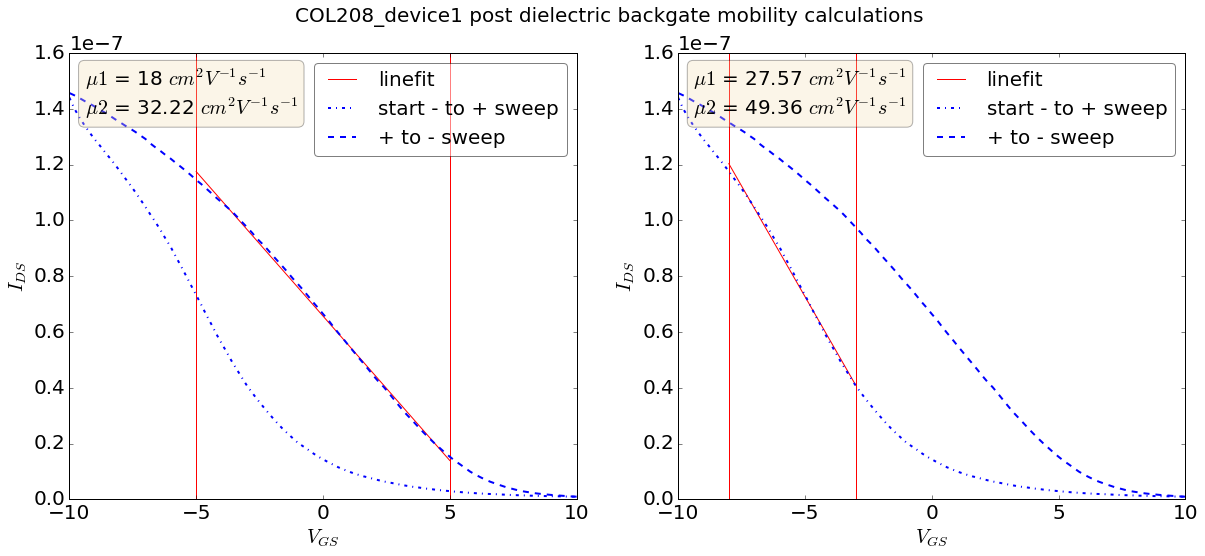

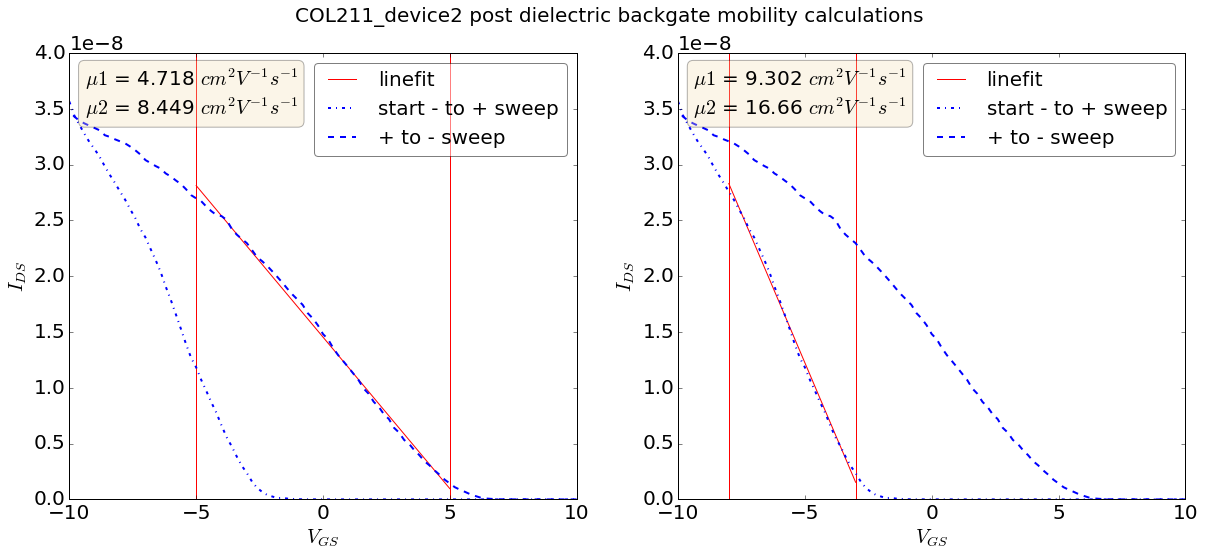

In [13]:
path1="data/COL208_device1_postdielelectric_FET_2016_05_28_1312.csv"
path2="data/COL211_device2_postdielelectric_FET_2016_05_28_1322.csv"
test_data=np.loadtxt(fname=path1,skiprows=1,delimiter=',')


def mobility_variation_2plots(path,save=False,Length=60e-6,Width=30e-6):
    data=np.loadtxt(fname=path,skiprows=1,delimiter=',')
    if len(data[:,0])<202:
        print(path," not plotted, incomplete data")
        return
    
    fig=plt.figure(figsize=(20,8))
    ax1 = plt.subplot(1,2, 1)
    ax2 = plt.subplot(1,2, 2)

    linefit_xrange(ax1,data[:,0],data[:,2],-5,5,Length,Width,forward=False)
    linefit_xrange(ax2,data[:,0],data[:,2],-8,-3,Length,Width,forward=True)

    plotupdown(ax1,data[:,0],data[:,2])
    plotupdown(ax2,data[:,0],data[:,2])
    format_axis(ax1,"$V_{GS}$","$I_{DS}$")
    format_axis(ax2,"$V_{GS}$","$I_{DS}$")
    fig.suptitle(os.path.basename(path)[:14]+" post dielectric backgate mobility calculations",fontsize=20)
    
    if save:
        checkdir("plots")

        name = os.path.basename(path).replace(".csv", "_mobility_plt.jpg")
        fig.savefig("plots/" + name, format="jpg")
        plt.close(fig)
mobility_variation_2plots(path1,save=False)
mobility_variation_2plots(path2,save=False)

In [16]:
for path in os.listdir("data"):
    mobility_variation_2plots(os.path.join("data",path),save=True)
#     print(path)


data/COL216_device1_postdielelectric_FET_2016_05_28_1400.csv  not plotted, incomplete data
data/COL227_device1_postdielelectric_FET_2016_05_28_1405.csv  not plotted, incomplete data
data/COL214_device3_postdielelectric_FET_2016_05_28_1345.csv  not plotted, incomplete data
data/COL216_device3_postdielelectric_FET_2016_05_28_1403.csv  not plotted, incomplete data
data/COL237_device3_postdielectric_FET_2016_05_28_1420.csv  not plotted, incomplete data
data/COL238_device1_postdielectric_FET_2016_05_28_1422.csv  not plotted, incomplete data
data/COL211_device1_postdielelectric_FET_2016_05_28_1316.csv  not plotted, incomplete data
data/COL256_device3_postdielectric_FET_2016_05_28_1449.csv  not plotted, incomplete data
data/COL214_device2_postdielelectric_FET_2016_05_28_1345.csv  not plotted, incomplete data
data/COL214_device1_postdielelectric_FET_2016_05_28_1344.csv  not plotted, incomplete data
data/COL227_device3_postdielelectric_FET_2016_05_28_1414.csv  not plotted, incomplete data


In [17]:
mobility_variation_2plots("data/COL208_device1_postdielelectric_FET_2016_05_28_1312.csv",Length=80e-6,Width=60e-6,save=True)
mobility_variation_2plots("data/COL211_device2_postdielelectric_FET_2016_05_28_1322.csv",Length=60e-6,Width=60e-6,save=True)